<a href="https://colab.research.google.com/github/m-adeleke1/PyTorch_Projects/blob/main/PyTorch_Medical_Text_Summarization_Assistant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Medical Text Summarization Assistant — Project Overview

This project is designed to help beginners learn PyTorch through hands-on experience while also exploring how large language models (LLMs) like OpenAI’s GPT models and Anthropic’s Claude can be combined with neural networks for real-world tasks. The focus is on medical text classification and summarization, using public datasets of de-identified clinical transcriptions. It demonstrates how to bridge traditional deep learning (PyTorch) with modern APIs for natural language generation.

#Project Goals 🎯

Practice PyTorch fundamentals: Learn how to tokenize text, build vocabularies, create datasets and loaders, define models, train, validate, and evaluate.

Apply to a real domain: Classify medical transcriptions by specialty (e.g., cardiology, neurology, oncology).

Integrate with LLMs: Use OpenAI and Claude APIs to generate patient-friendly summaries of medical notes after classification.

Develop intuition: Understand the full data → model → evaluation → application pipeline.


#Workflow 🔄


##1. Data preparation

Dataset: We use the MTSamples dataset, which contains medical transcriptions labeled by specialty. Importantly, this dataset is public and de-identified, making it safe for experimentation.

Tokenization: Text is split into tokens (lowercased words/numbers).

Vocabulary building: We build a dictionary of the most frequent words in the training split. Rare words are mapped to <unk> (unknown). Padding tokens <pad> are added to standardize batch sizes.

Numericalization: Each word in a note is replaced with its integer ID. Labels (specialties) are mapped to numeric class IDs.

👉 This step teaches how raw text is transformed into tensors suitable for deep learning.


##2. Dataset & DataLoader

A custom PyTorch Dataset returns (input_ids, label) pairs.

A custom collate_fn pads sequences within each batch to the same length and tracks true sequence lengths.

👉 This ensures that the model handles variable-length notes properly and avoids learning from padding.


##3. Model definition (BiLSTM classifier)

We implement a bi-directional LSTM (BiLSTM):

Embedding layer: Converts token IDs into dense vectors.

BiLSTM: Processes sequences forward and backward, capturing context on both sides of a word.

Pooling: Concatenates the last hidden states from both directions.

Dropout + Linear layer: Regularizes and maps to class logits.

👉 This demonstrates core sequence modeling in PyTorch. You learn about embeddings, recurrent layers, and why lengths + packing matter for efficient training.


##4. Training loop

Loss: Cross-entropy loss compares predicted logits to true labels.

Optimizer: AdamW updates weights efficiently.

Gradient clipping: Prevents exploding gradients (a common RNN issue).

Evaluation: After each epoch, validation loss and accuracy are computed.

Early stopping: Training halts if validation accuracy stops improving.

👉 This reinforces the typical PyTorch workflow: forward → loss → backward → step → validate → checkpoint.


## 5. Inference

Once trained, the model can classify new notes by specialty. We also compute class probabilities so we know not just what the model predicts, but also how confident it is.

👉 This bridges the gap between “training a model” and actually using it in practice.


## 6. Summarization with LLMs

The project then integrates with OpenAI and Claude APIs:

The classified note is passed to an LLM.

The LLM generates a plain-language summary for patients, with disclaimers that it is educational only, not medical advice.

Both OpenAI and Claude are supported, showing how to orchestrate multiple providers.

👉 This step demonstrates how traditional ML outputs (classification) can be enriched by modern LLMs to add value in applications.


## 7. Extensions (optional, but recommended)

Confusion matrix: Visualize which specialties get mixed up.

Error analysis: Inspect misclassified notes to understand model weaknesses.

Transfer learning: Swap the BiLSTM with DistilBERT for higher accuracy.

Gradio app: Build an interactive UI where users can paste a note, see the predicted specialty, and get summaries side-by-side.

👉 These extensions reinforce best practices in ML: interpret results, iterate on models, and make your work usable.


## Key Learning Takeaways ⚠️

PyTorch fundamentals: You see the full path from data preprocessing to a trained classifier.

Shape discipline: Managing [batch, time, features] tensors is central to RNNs and LSTMs.

Evaluation mindset: Accuracy, confusion matrices, and error analysis guide improvements.

Integration skills: LLM APIs can be layered on top of deep learning models to produce user-facing features.

Applied context: Using medical text highlights challenges of domain-specific NLP, such as jargon, class imbalance, and the need for interpretability.


##Disclaimer ⚠️

This project is educational only. It uses de-identified, publicly available medical text. Predictions and summaries from this notebook should never be used for real medical advice or decision-making.


##Bottom line:

By completing this notebook, you’ll gain a strong, practical understanding of how PyTorch models are built and trained, how to prepare text for sequence models, how to validate and improve them, and how to connect their outputs to modern APIs like OpenAI and Claude. This mirrors what real AI engineers do when combining deep learning foundations with powerful external tools to create useful applications.

In [13]:
#@title ✅ Setup: install libraries
!pip -q install -U torch torchvision torchaudio datasets transformers scikit-learn tqdm openai anthropic

import os, re, math, random, json, time, getpass
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
from datasets import load_dataset
from tqdm.auto import tqdm

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [14]:
#@title 🔑 Load API keys from Colab secrets (or env), no prompts
import os

# Try to read from Colab's Secrets (Tools → Secrets and variables → User secrets)
try:
    from google.colab import userdata  # available in Colab
    OPENAI_API_KEY = userdata.get('OPENAI_API_KEY') or os.environ.get('OPENAI_API_KEY', '')
    ANTHROPIC_API_KEY = userdata.get('ANTHROPIC_API_KEY') or os.environ.get('ANTHROPIC_API_KEY', '')
except Exception:
    # Fallback if userdata isn't available
    OPENAI_API_KEY = os.environ.get('OPENAI_API_KEY', '')
    ANTHROPIC_API_KEY = os.environ.get('ANTHROPIC_API_KEY', '')

if OPENAI_API_KEY:
    os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
if ANTHROPIC_API_KEY:
    os.environ['ANTHROPIC_API_KEY'] = ANTHROPIC_API_KEY

print("OpenAI set:", bool(os.environ.get("OPENAI_API_KEY")))
print("Anthropic set:", bool(os.environ.get("ANTHROPIC_API_KEY")))

OpenAI set: True
Anthropic set: True


#Build vocab & datasets (beginner-friendly)<br><br>

Before a neural network can learn from text, we have to turn text into numbers. This cell does exactly that, step by step:<br><br>

##1) Split your data into training and validation

We divide the dataset into:

Training: what the model sees and learns from.

Validation: held-out examples to check how well the model generalizes to new data.

This prevents “peeking” and gives an honest progress report during training.<br><br>

##2) Tokenize the text (turn sentences → tokens)

We take each clinical note (a long string) and break it into tokens (usually words, numbers, and a few punctuation marks). We also lowercase and remove odd characters so the model isn’t distracted by formatting noise.
Why do this? Neural nets don’t understand raw text; they need consistency (e.g., “Patient” and “patient” should be treated the same).<br><br>

##3) Build a vocabulary (tokens → integer IDs)

From the training split only, we count how often each token appears. Then we create a vocabulary (a look-up table) that maps the most common tokens to IDs:

Keep only the top MAX_VOCAB most frequent tokens (keeps memory small).

Drop ultra-rare tokens (below MIN_FREQ times), because they don’t help much and add noise.

Add two special tokens:

<pad>: used to pad shorter notes so every example in a batch has the same length.

<unk>: “unknown”; used when we meet a token that isn’t in the vocabulary (too rare or completely new at test time).

Now any note can be turned into a list of integers: each token → its ID (or <unk> if missing).<br><br>

##4) Cap the sequence length

We clip each tokenized note to MAX_LEN. This keeps batches a manageable size and prevents a few very long notes from slowing everything down or running out of memory.<br><br>

##5) Encode labels (names → class IDs)

Each medical specialty (e.g., “cardiology”) becomes an integer label (0, 1, 2, …). This lets us compute loss and accuracy later.<br><br>

##6) Build a PyTorch Dataset and DataLoader

Dataset: When you ask for item i, it returns (input_ids, label):

input_ids is a 1D tensor of token IDs for that note.

label is the class ID for the note’s specialty.

collate function (the quiet hero): When the DataLoader collects a batch of items with different lengths, it:

Pads each sequence to the same length (using <pad>).

Returns a lengths tensor telling us how long each note really is (before padding).

Packages everything into neat tensors for the model.

Why is the collate function important? RNNs/LSTMs process sequences; they need the true lengths so they can ignore padding and avoid wasting work. In PyTorch, we pass these lengths to packed sequences (more on that in the model explanation), which lets the LSTM skip the fake <pad> tokens entirely.<br><br>

##7) Summary of what you gain

Your text is now consistent numeric tensors.

The model can train in batches even though notes have different lengths.

You’ve set up the exact same data plumbing you’ll use for more advanced models later (BERT, etc.).

In [16]:
#@title 🔤 Build/restore vocab & labels (robust to missing text)
import re
from collections import Counter
from tqdm.auto import tqdm

MAX_VOCAB = 20000
MIN_FREQ  = 2
MAX_LEN   = 256

def basic_tokenize(text):
    # Robustify: handle None or non-string inputs
    if text is None:
        return []
    if not isinstance(text, str):
        try:
            text = str(text)
        except Exception:
            return []
    text = text.strip()
    if not text:
        return []
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s\-\/\.\,:%\(\)]", " ", text)
    toks = re.findall(r"[a-z0-9]+(?:[\-\/][a-z0-9]+)?|[%\.\,\:\(\)]", text)
    return toks

# 1) Build vocab from training split
counter = Counter()
skipped = 0
for rec in tqdm(train_ds, desc="Counting tokens for vocab"):
    txt = rec.get(TEXT_COL, None)
    toks = basic_tokenize(txt)
    if not toks:
        skipped += 1
        continue
    counter.update(toks)

print(f"Skipped {skipped} training rows with empty/None text.")

# 2) Vocab + special tokens
special_tokens = ["<pad>", "<unk>"]
most_common = [w for w, c in counter.most_common(MAX_VOCAB) if c >= MIN_FREQ]
itos = special_tokens + most_common
stoi = {w: i for i, w in enumerate(itos)}
PAD_ID = stoi["<pad>"]
UNK_ID = stoi["<unk>"]

# 3) Encoder
def encode(text, max_len=MAX_LEN):
    toks = basic_tokenize(text)[:max_len]
    return [stoi.get(t, UNK_ID) for t in toks]

# 4) Labels
labels = sorted(set(train_ds[LABEL_COL]))
label2id = {l: i for i, l in enumerate(labels)}
id2label = {i: l for l, i in label2id.items()}
NUM_CLASSES = len(labels)

print("Vocab built:",
      f"\n  len(itos)={len(itos)}, PAD_ID={PAD_ID}, UNK_ID={UNK_ID}",
      f"\nLabels ({NUM_CLASSES}): {labels[:8]}{' ...' if len(labels)>8 else ''}")

Counting tokens for vocab:   0%|          | 0/4249 [00:00<?, ?it/s]

Skipped 28 training rows with empty/None text.
Vocab built: 
  len(itos)=20002, PAD_ID=0, UNK_ID=1 
Labels (40): [' Allergy / Immunology', ' Autopsy', ' Bariatrics', ' Cardiovascular / Pulmonary', ' Chiropractic', ' Consult - History and Phy.', ' Cosmetic / Plastic Surgery', ' Dentistry'] ...


In [17]:
#@title 🧪 Health check: required globals
required = [
    "train_ds","valid_ds","TEXT_COL","LABEL_COL",
    "itos","stoi","PAD_ID","UNK_ID",
    "labels","label2id","id2label","NUM_CLASSES"
]
missing = [r for r in required if r not in globals()]
assert not missing, f"Missing: {missing}"

print("All good ✅")
print("Text column:", TEXT_COL, "| Label column:", LABEL_COL)
print("Vocab size:", len(itos), "| Num classes:", NUM_CLASSES)

All good ✅
Text column: transcription | Label column: medical_specialty
Vocab size: 20002 | Num classes: 40


## 1. Embedding layer

Each word ID is mapped to a vector — basically a list of numbers that represents the word in a way the model can learn from.

Think of embeddings as “word fingerprints.” Words with similar meanings will end up with similar fingerprints once trained.

Output shape: [batch, time, embed_dim]

batch = how many notes we process at once.

time = how many words are in each note.

embed_dim = how many numbers represent each word.

The padding_idx means if we added fake tokens to make all notes the same length, those fake tokens will always be represented by zeros and won’t affect learning.


## 2. BiLSTM layer

LSTM stands for Long Short-Term Memory. It’s a special type of neural network that reads sequences word by word and builds up an internal memory about what it has seen.

Hidden states: At each step, the LSTM keeps a “hidden state,” which is like a mental summary of the words it has read so far.

Bidirectional (BiLSTM): Instead of just reading left-to-right, the model also reads right-to-left. This is important because meaning often depends on context both before and after a word (e.g., “no evidence of pneumonia” vs. “pneumonia detected”).

So after running a note through the BiLSTM, we get two hidden states: one from the forward read, one from the backward read. We concatenate them (stick them together) to form a bigger summary vector [B, 2H].


## 3. Packed sequences (handling padding)

Since notes are different lengths, we use padding to make them fit in a batch. But we don’t want the LSTM to waste time reading those fake <pad> tokens.

pack_padded_sequence is a PyTorch trick: it tells the LSTM, “ignore the padding, only read the real words.” This makes training faster and prevents the model from accidentally learning patterns from padding.

Afterward, we don’t need to “unpack” since we only care about the final hidden states.


## 4. Dropout + Linear layer (classifier head)

Dropout: Randomly turns off parts of the vector during training, which helps the model not memorize the training data too closely (reduces overfitting).

Linear layer: Takes the [B, 2H] vector and maps it to a new vector with length = number of classes (specialties).

That last vector is called logits.

Logits are just the raw output numbers before they get converted into probabilities.

For example, for 5 classes, logits might be [2.1, -1.4, 0.3, 0.9, 1.7].

Then we apply softmax (a mathematical function) to turn them into probabilities that sum to 1, like [0.48, 0.01, 0.05, 0.10, 0.36].


## Key Definitions (recap)

Hidden state: The LSTM’s internal memory at each step, like a running summary of the sequence so far.

Pooling: Taking many values (like hidden states across time) and combining them into one summary (here, we just take the final ones).

Packing: A PyTorch technique to skip over padding tokens inside the LSTM.

Logits: Raw model outputs before they’re turned into probabilities.

Why this model is useful

It’s small, interpretable, and efficient.

It shows you how neural networks handle text sequences.

It’s a great stepping stone: once you understand LSTMs, you’ll be ready to appreciate transformers (like BERT), which replace recurrence with self-attention for even better handling of long context.

In [18]:
#@title 🧠 Define the model (safe constructor)
import torch
from torch import nn

class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128,
                 num_classes=None, pad_idx=None, dropout=0.2):
        super().__init__()
        assert num_classes is not None, "num_classes must be provided"
        assert pad_idx is not None, "pad_idx must be provided"

        self.emb = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True,
                            bidirectional=True, num_layers=1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x, lengths):
        emb = self.emb(x)  # [B, T, E]
        packed = nn.utils.rnn.pack_padded_sequence(
            emb, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        _, (hn, _) = self.lstm(packed)  # hn: [2, B, H]
        h = torch.cat([hn[0], hn[1]], dim=1)  # [B, 2H]
        h = self.dropout(h)
        logits = self.fc(h)  # [B, C]
        return logits

model = BiLSTMClassifier(
    vocab_size=len(itos),
    num_classes=NUM_CLASSES,
    pad_idx=PAD_ID
).to(device)

print("Model params (M):", sum(p.numel() for p in model.parameters())/1e6)

Model params (M): 2.834728


# Training Loop (Beginner-Friendly Explanation)

The training loop is the beating heart of any PyTorch project. It’s where the model actually learns by looking at examples, making guesses, and adjusting itself based on mistakes. Think of it like practicing flashcards: you look at the card, guess the answer, check if you’re right, and update your memory.

Here’s what happens step by step:

## 1. Loss and optimizer

Loss function: This is the measure of “how wrong” the model is.

We use CrossEntropyLoss, which compares the model’s guesses (logits) to the correct class (the real specialty).

If the model’s probability for the right class is high, loss is small. If it’s low, loss is large.

Optimizer: This is the tool that updates the model’s numbers (weights) based on the loss.

We use AdamW, a modern optimizer that usually works well “out of the box.”

Think of it like a smart calculator that figures out how big each update step should be.<br><br>


## 2. Epochs and batches

Epoch: One full pass through the training data. Usually we need several epochs before the model learns well.

Batch: Instead of feeding the model the entire dataset at once, we give it smaller groups (batches). This is faster and makes training more stable.

For each batch:

Move data to device: Put the batch on GPU (if available) so it runs faster.

Clear gradients: optimizer.zero_grad() wipes out leftover information from the last batch.

Forward pass: The model processes the batch and outputs predictions (logits).

Compute loss: Compare predictions to true labels.

Backward pass: loss.backward() calculates how much each weight contributed to the error. This is called backpropagation.

Gradient clipping: We limit the size of updates (clip_grad_norm_) so the model doesn’t “explode” with huge jumps (a known problem in RNNs).

Optimizer step: Apply the weight updates to make the model a little better.

This cycle repeats for every batch in the training data.<br><br>


##3. Validation and metrics

After training on all batches in an epoch, we pause to check how the model does on the validation set (data the model has never seen during training).

Turn off training behaviors: model.eval() disables things like dropout, so the model behaves predictably. torch.no_grad() tells PyTorch we don’t need gradients (saves memory and time).

Compute validation loss and accuracy:

Loss tells us how “off” the model still is.

Accuracy is easy to interpret: the fraction of notes classified correctly.

Track predictions: We store the true labels and predicted labels so we can later make reports or confusion matrices.

This step helps us spot if the model is overfitting (memorizing training data but failing on new data).<br><br>


##4. Early stopping and checkpoints

We keep track of the best validation accuracy so far.

If the model improves, we save its weights (best_model.pt).

If it doesn’t improve for a few epochs (patience), we stop training early to avoid wasting time and overfitting.

👉 Early stopping is like saying, “Okay, you’ve practiced enough. More practice isn’t helping, so let’s stop here.”

Why accuracy and loss?

Loss gives a smooth measure for the optimizer to minimize.

Accuracy is more intuitive for humans: “How often is the model right?”

Watching both helps us see if the model is learning in a balanced way.<br><br>

###Big picture

The training loop is where PyTorch models learn by trial and error:

Make a guess (forward pass).

Check how wrong it was (loss).

Learn from mistakes (backward pass + optimizer step).

Validate progress.

Stop when things stop improving.

Once you internalize this rhythm, you’ll notice that almost every PyTorch project — text, images, audio, or otherwise — follows the same training loop skeleton.

In [22]:
#@title 🚂 Train loop (writes best_model.pt)
from pathlib import Path
from torch import nn

# define evaluate() here so validation can reuse it later
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, total, correct = 0.0, 0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for X, y, lengths in loader:
            X, y, lengths = X.to(device), y.to(device), lengths.to(device)
            logits = model(X, lengths)
            loss = criterion(logits, y)
            total_loss += float(loss.item()) * y.size(0)
            preds = logits.argmax(dim=1)
            correct += int((preds == y).sum().item())
            total += int(y.size(0))
            y_true.extend(y.cpu().tolist()); y_pred.extend(preds.cpu().tolist())
    avg_loss = total_loss / max(total, 1)
    acc = correct / max(total, 1)
    return avg_loss, acc, (y_true, y_pred)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)

EPOCHS = 3          # keep small for a quick run
patience = 2        # early stopping patience
best_val_acc = 0.0
waited = 0
CKPT_PATH = "best_model.pt"

for epoch in range(1, EPOCHS + 1):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}")
    for X, y, lengths in pbar:
        X, y, lengths = X.to(device), y.to(device), lengths.to(device)
        optimizer.zero_grad()
        logits = model(X, lengths)
        loss = criterion(logits, y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        pbar.set_postfix(loss=float(loss.item()))

    val_loss, val_acc, _ = evaluate(model, valid_loader, criterion)
    print(f"VAL  loss={val_loss:.4f}  acc={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc, waited = val_acc, 0
        torch.save(model.state_dict(), CKPT_PATH)
        print(f"✅ Saved new best to {CKPT_PATH}")
    else:
        waited += 1
        if waited >= patience:
            print("Early stopping.")
            break

print("Best val acc:", best_val_acc)
print("Checkpoint exists:", Path(CKPT_PATH).exists())

Epoch 1/3:   0%|          | 0/133 [00:00<?, ?it/s]

VAL  loss=2.4644  acc=0.3573
✅ Saved new best to best_model.pt


Epoch 2/3:   0%|          | 0/133 [00:00<?, ?it/s]

VAL  loss=2.3731  acc=0.3440


Epoch 3/3:   0%|          | 0/133 [00:00<?, ?it/s]

VAL  loss=2.3853  acc=0.3133
Early stopping.
Best val acc: 0.35733333333333334
Checkpoint exists: True


#Validation Report<br>

After training, it’s not enough to just know the overall accuracy. The validation report gives a detailed breakdown of performance by class (specialty).

It shows precision, recall, and F1 score for each class.

This tells us whether the model is strong across the board or only good at certain specialties.

For example: maybe it does well on “general medicine” but struggles with “urology.”

👉 Why it matters: This is where we move from “the model is ~80% accurate” to “the model is strong here, weak there.” That insight guides improvements like balancing the dataset or tweaking the architecture.

In [23]:
#@title 📊 Validation report (load best checkpoint)
import os
from sklearn.metrics import classification_report

CKPT_PATH = "best_model.pt"
if os.path.exists(CKPT_PATH):
    model.load_state_dict(torch.load(CKPT_PATH, map_location=device))
    print(f"Loaded checkpoint: {CKPT_PATH}")
else:
    print("⚠️ Still no checkpoint on disk — using current weights.")

model.eval()
val_loss, val_acc, (y_true, y_pred) = evaluate(model, valid_loader, criterion)
print(f"\nVAL  loss={val_loss:.4f}  acc={val_acc:.4f}\n")
print(classification_report(
    y_true, y_pred,
    target_names=[id2label[i] for i in range(NUM_CLASSES)],
    digits=3
))

Loaded checkpoint: best_model.pt

VAL  loss=2.4644  acc=0.3573

                                precision    recall  f1-score   support

          Allergy / Immunology      0.000     0.000     0.000         2
                       Autopsy      0.000     0.000     0.000         1
                    Bariatrics      0.000     0.000     0.000         3
    Cardiovascular / Pulmonary      0.176     0.054     0.082        56
                  Chiropractic      0.000     0.000     0.000         1
    Consult - History and Phy.      0.251     0.809     0.383        68
    Cosmetic / Plastic Surgery      0.000     0.000     0.000         7
                     Dentistry      0.000     0.000     0.000         3
                   Dermatology      0.000     0.000     0.000         8
          Diets and Nutritions      0.000     0.000     0.000         2
             Discharge Summary      0.370     0.769     0.500        13
          ENT - Otolaryngology      0.000     0.000     0.000        17

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


#Classify a New Clinical Note<br>

This cell shows how to use the model in practice.

You paste in a note (string of text).

It runs through the preprocessing pipeline → model → prediction.

The output is:

The predicted specialty.

The model’s confidence (probability).

The top-5 class probabilities (so you can see other likely candidates).

👉 Why it matters: This is the “deployment mindset.” You’ve trained your model — now here’s how an end user could actually use it in a system.

In [25]:
#@title 🔎 Classify a new clinical note
import torch
import torch.nn.functional as F
import numpy as np
import random

def predict_specialty(note: str):
    """
    Returns: (predicted_label: str, confidence: float, probs: np.ndarray[num_classes])
    """
    # Guard against None/empty
    if note is None or (isinstance(note, str) and note.strip() == ""):
        note = "<empty>"

    model.eval()
    with torch.no_grad():
        ids = torch.tensor(encode(note), dtype=torch.long)[None, :]  # [1, T]
        lengths = torch.tensor([ids.shape[1]], dtype=torch.long)     # [1]
        ids, lengths = ids.to(device), lengths.to(device)
        logits = model(ids, lengths)                                 # [1, C]
        probs = F.softmax(logits, dim=1).squeeze(0).cpu().numpy()    # [C]
    top_idx = int(np.argmax(probs))
    return id2label[top_idx], float(probs[top_idx]), probs

# Quick smoke test on a random validation row
sample = valid_ds[random.randrange(len(valid_ds))]
pred_label, pred_p, _ = predict_specialty(sample[TEXT_COL])
print("Predicted:", pred_label, f"({pred_p:.2f})")
print("True label:", sample[LABEL_COL])

Predicted:  Discharge Summary (0.69)
True label:  Cardiovascular / Pulmonary


#Summarizers (OpenAI + Claude)<br>

These functions call the OpenAI and Claude APIs to generate human-friendly summaries.

Input: the original note + the predicted specialty.

Output: a plain language summary (with disclaimers that it’s educational only).

Why both? To show how to integrate multiple LLM providers in parallel.

👉 Why it matters: This step combines your classifier (deep learning in PyTorch) with LLMs (via APIs). It’s a taste of how real-world AI products blend different technologies: one model provides structure, another model provides fluency.

In [26]:
#@title 🧾 Summarizers (OpenAI + Claude)
SYSTEM_CONTENT = (
    "You are a medical writing assistant. Summarize the clinical note in plain, layperson language. "
    "Keep it concise (120–200 words), preserve important clinical facts (diagnoses, tests, treatments), "
    "avoid speculation, and add a final line: 'This summary is for education only and is not medical advice.'"
)

def openai_summarize(note: str, specialty: str = None, model_name: str = "gpt-4o-mini"):
    if not os.environ.get("OPENAI_API_KEY"):
        return "(OpenAI API key not set.)"
    from openai import OpenAI
    client = OpenAI()
    user_prompt = f"Specialty: {specialty or 'unknown'}\n\nNote:\n{note}"
    # Try modern Responses API, then fall back to Chat Completions for compatibility
    try:
        resp = client.responses.create(
            model=model_name,
            input=[{"role":"system","content":SYSTEM_CONTENT},
                   {"role":"user","content":user_prompt}],
            temperature=0.2,
            max_output_tokens=300
        )
        return resp.output_text
    except Exception:
        resp = client.chat.completions.create(
            model=model_name,
            messages=[{"role":"system","content":SYSTEM_CONTENT},
                      {"role":"user","content":user_prompt}],
            temperature=0.2,
            max_tokens=300
        )
        return resp.choices[0].message.content

def claude_summarize(note: str, specialty: str = None, model_name: str = "claude-3-5-haiku-latest"):
    if not os.environ.get("ANTHROPIC_API_KEY"):
        return "(Anthropic API key not set.)"
    import anthropic
    client = anthropic.Anthropic()
    user_prompt = f"Specialty: {specialty or 'unknown'}\n\nNote:\n{note}"
    msg = client.messages.create(
        model=model_name,
        max_tokens=300,
        temperature=0.2,
        system=SYSTEM_CONTENT,
        messages=[{"role":"user", "content": user_prompt}]
    )
    # Extract plain text blocks
    out = []
    for block in msg.content:
        if getattr(block, "type", None) == "text":
            out.append(block.text)
    return "\n".join(out) if out else str(msg)

#Confusion Matrix (matplotlib-only) + Most-Confused Pairs<br>

Accuracy hides mistakes. The confusion matrix reveals them.

Each row = true class, each column = predicted class.

A perfect model would be a diagonal line.

Off-diagonal entries = mistakes (confusions).

We also list the most confused pairs: which specialties the model mixes up most.

👉 Why it matters: It’s one of the best diagnostic tools. It lets you see if your model’s errors are random noise or systematic (e.g., cardiology vs pulmonology overlap). That tells you whether to get more data, rebalance classes, or change model capacity.

Validation acc: 0.3573


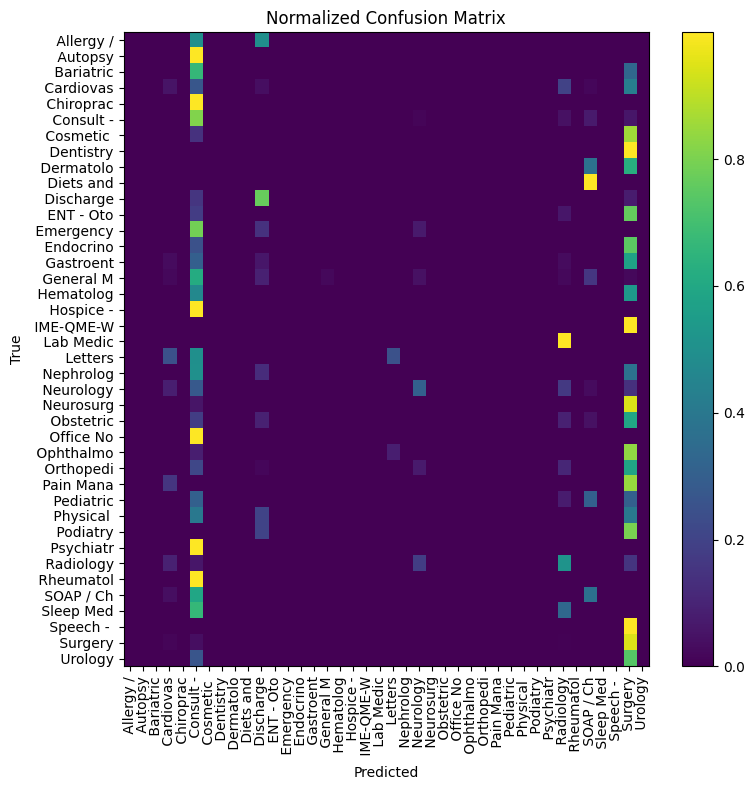


Top confused pairs (true -> predicted) by raw count:
 Orthopedic ->  Surgery : 33
 General Medicine ->  Consult - History and Phy. : 27
 Cardiovascular / Pulmonary ->  Surgery : 24
 Gastroenterology ->  Surgery : 19
 Neurosurgery ->  Surgery : 17
 SOAP / Chart / Progress Notes ->  Consult - History and Phy. : 16
 Cardiovascular / Pulmonary ->  Consult - History and Phy. : 15
 Urology ->  Surgery : 14
 ENT - Otolaryngology ->  Surgery : 13
 Obstetrics / Gynecology ->  Surgery : 13

--- Sample Misclassifications ---

True:  Orthopedic | Pred:  Consult - History and Phy. (0.37)
REASON FOR CONSULT: , Medical management, status post left total knee arthroplasty.,PAST MEDICAL HISTORY:,1.  Polyarthritis.,2.  Acromegaly.,3.  Hypothyroidism.,4.  Borderline hypertension.,5.  Obesity.,PAST SURGICAL HISTORY: , Hernia repair, resection of tumor, right thumb arthrodesis, carpal tunnel decompression, bilateral hip replacement, right total knee replacement about 2 months ago, open reduction of left e

In [27]:
#@title 📈 Confusion Matrix (matplotlib-only) + Most-Confused Pairs
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Recompute validation predictions to ensure we have arrays aligned
model.load_state_dict(torch.load("best_model.pt", map_location=device))
val_loss, val_acc, (y_true, y_pred) = evaluate(model, valid_loader, criterion)
print(f"Validation acc: {val_acc:.4f}")

cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
cm_norm = cm.astype(np.float32) / (cm.sum(axis=1, keepdims=True) + 1e-9)

plt.figure(figsize=(8, 8))
plt.imshow(cm_norm, aspect='auto')  # don't set explicit colors by policy
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
tick_labs = [id2label[i][:10] for i in range(NUM_CLASSES)]  # short labels
plt.xticks(range(NUM_CLASSES), tick_labs, rotation=90)
plt.yticks(range(NUM_CLASSES), tick_labs)
plt.colorbar()
plt.tight_layout()
plt.show()

# Most-confused class pairs (excluding diagonal)
pairs = []
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        if i != j and cm[i, j] > 0:
            pairs.append(((i, j), cm[i, j]))
pairs_sorted = sorted(pairs, key=lambda x: -x[1])[:10]

print("\nTop confused pairs (true -> predicted) by raw count:")
for (i, j), c in pairs_sorted:
    print(f"{id2label[i]} -> {id2label[j]} : {c}")

# Inspect a few misclassified examples
def show_misclassified(n=5):
    shown = 0
    print("\n--- Sample Misclassifications ---")
    # Iterate the valid set again to show examples
    for idx in range(len(valid_ds)):
        true_lbl = label2id[valid_ds[idx][LABEL_COL]]
        text = valid_ds[idx][TEXT_COL]
        pred_lbl, p, _ = predict_specialty(text)
        if pred_lbl != id2label[true_lbl]:
            print(f"\nTrue: {id2label[true_lbl]} | Pred: {pred_lbl} ({p:.2f})")
            print(text[:600], "..." if len(text) > 600 else "")
            shown += 1
            if shown >= n:
                break

show_misclassified(n=5)

#DistilBERT: Tokenizer, Dataset, and Model

This cell switches from the BiLSTM (built from scratch) to a pretrained transformer model.

Tokenizer: DistilBERT comes with its own tokenizer that splits words into subword units. This handles rare words and typos much better than a simple word tokenizer.

Dataset: We re-wrap the data using HuggingFace’s dataset utilities, mapping text → token IDs using the transformer’s tokenizer.

Model: We load AutoModelForSequenceClassification (DistilBERT with a classification head).

👉 Why it matters: Transformers are state-of-the-art for NLP. You see how easy it is to go from scratch → transfer learning, and why modern practice almost always uses pretrained models.

In [30]:
# Remove rows where TEXT_COL is None or empty
def _has_text(example):
    txt = example.get(TEXT_COL, None)
    return isinstance(txt, str) and txt.strip() != ""

train_ds = train_ds.filter(_has_text)
valid_ds = valid_ds.filter(_has_text)

print("After filtering:", len(train_ds), len(valid_ds))

Filter:   0%|          | 0/4249 [00:00<?, ? examples/s]

Filter:   0%|          | 0/750 [00:00<?, ? examples/s]

After filtering: 4221 745


In [31]:
#@title 🤖 DistilBERT: Tokenizer, Dataset, and Model
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from transformers import get_linear_schedule_with_warmup

TRANSFORMER_MODEL = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(TRANSFORMER_MODEL)

# Build HF Dataset objects with our columns
def encode_examples(batch):
    return tokenizer(batch[TEXT_COL], truncation=True, max_length=256)

# Use the earlier train_ds / valid_ds
encoded_train = train_ds.map(encode_examples, batched=True, remove_columns=[TEXT_COL])
encoded_valid = valid_ds.map(encode_examples, batched=True, remove_columns=[TEXT_COL])

# Add integer labels
encoded_train = encoded_train.map(lambda b: {"labels": [label2id[l] for l in b[LABEL_COL]]}, batched=True)
encoded_valid = encoded_valid.map(lambda b: {"labels": [label2id[l] for l in b[LABEL_COL]]}, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest", return_tensors="pt")

tfm_model = AutoModelForSequenceClassification.from_pretrained(
    TRANSFORMER_MODEL, num_labels=NUM_CLASSES
).to(device)

print("Parameter count (M):", sum(p.numel() for p in tfm_model.parameters())/1e6)

Map:   0%|          | 0/4221 [00:00<?, ? examples/s]

Map:   0%|          | 0/745 [00:00<?, ? examples/s]

Map:   0%|          | 0/4221 [00:00<?, ? examples/s]

Map:   0%|          | 0/745 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Parameter count (M): 66.984232


#Train DistilBERT (quick)

We fine-tune DistilBERT on our dataset.

Fine-tuning = starting from a pretrained model and adjusting it on your dataset.

We use an optimizer (AdamW), a scheduler (to warm up the learning rate smoothly), and train for only a few epochs (because DistilBERT already “knows language”).

Validation accuracy is tracked, just like with BiLSTM.

👉 Why it matters: You get hands-on with transfer learning — the main way NLP models are built today. It’s faster, more accurate, and more practical than training from scratch.

In [33]:
#@title ✅ Clean encoded datasets and rebuild loaders
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import DataLoader

TRANSFORMER_MODEL = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(TRANSFORMER_MODEL)

# 1) (Re)encode robustly
def encode_examples(batch):
    texts = batch[TEXT_COL]
    clean_texts = []
    for t in texts:
        if t is None:
            clean_texts.append("")
        elif not isinstance(t, str):
            clean_texts.append(str(t))
        else:
            clean_texts.append(t)
    return tokenizer(clean_texts, truncation=True, max_length=256)

# Optional: filter out totally empty rows
def _has_text(example):
    txt = example.get(TEXT_COL, None)
    return isinstance(txt, str) and txt.strip() != ""

train_ds = train_ds.filter(_has_text)
valid_ds = valid_ds.filter(_has_text)

encoded_train = train_ds.map(encode_examples, batched=True)
encoded_valid = valid_ds.map(encode_examples, batched=True)

# 2) Add integer labels
encoded_train = encoded_train.map(lambda b: {"labels": [int(label2id[l]) for l in b[LABEL_COL]]}, batched=True)
encoded_valid = encoded_valid.map(lambda b: {"labels": [int(label2id[l]) for l in b[LABEL_COL]]}, batched=True)

# 3) Keep only model features
keep_cols = ["input_ids", "attention_mask", "labels"]
encoded_train = encoded_train.remove_columns([c for c in encoded_train.column_names if c not in keep_cols])
encoded_valid = encoded_valid.remove_columns([c for c in encoded_valid.column_names if c not in keep_cols])

# 4) Collator and loaders
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True, return_tensors="pt")

train_loader_tfm = DataLoader(encoded_train, batch_size=16, shuffle=True, collate_fn=data_collator)
valid_loader_tfm = DataLoader(encoded_valid, batch_size=32, shuffle=False, collate_fn=data_collator)

# 5) Model (re-)init
tfm_model = AutoModelForSequenceClassification.from_pretrained(
    TRANSFORMER_MODEL, num_labels=NUM_CLASSES
).to(device)

print("Train columns:", encoded_train.column_names)
print("Valid columns:", encoded_valid.column_names)
print("Sanity batch:")
batch = next(iter(train_loader_tfm))
print({k: (v.shape if hasattr(v, 'shape') else type(v)) for k, v in batch.items()})

Filter:   0%|          | 0/4221 [00:00<?, ? examples/s]

Filter:   0%|          | 0/745 [00:00<?, ? examples/s]

Map:   0%|          | 0/4221 [00:00<?, ? examples/s]

Map:   0%|          | 0/745 [00:00<?, ? examples/s]

Map:   0%|          | 0/4221 [00:00<?, ? examples/s]

Map:   0%|          | 0/745 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train columns: ['input_ids', 'attention_mask', 'labels']
Valid columns: ['input_ids', 'attention_mask', 'labels']
Sanity batch:
{'input_ids': torch.Size([16, 256]), 'attention_mask': torch.Size([16, 256]), 'labels': torch.Size([16])}


#Transformer Inference Helper<br>

This is the DistilBERT version of the “Classify a new clinical note” function.

Input: a note.

Processing: tokenizer → DistilBERT → logits → probabilities.

Output: predicted specialty, confidence, and full probability distribution.

👉 Why it matters: It shows how similar inference looks, regardless of whether you’re using your own BiLSTM or a pretrained transformer. Once you understand the pattern, you can swap in any model.

In [34]:
#@title 🔎 Transformer Inference Helper
from transformers import AutoModelForSequenceClassification

def predict_specialty_transformer(note: str, model_dir="./tfm_best"):
    tok = AutoTokenizer.from_pretrained(model_dir)
    mdl = AutoModelForSequenceClassification.from_pretrained(model_dir).to(device)
    mdl.eval()
    with torch.no_grad():
        batch = tok(note, return_tensors="pt", truncation=True, max_length=256).to(device)
        out = mdl(**batch)
        probs = torch.softmax(out.logits, dim=1).squeeze(0).cpu().numpy()
    top_idx = int(np.argmax(probs))
    return id2label[top_idx], float(probs[top_idx]), probs

#Gradio App

This turns the whole project into an interactive web app.

User input: A textbox where you paste a note.

Options: Choose BiLSTM or DistilBERT; choose OpenAI or Claude summarization.

Outputs: Predicted specialty, top-5 probabilities, and summaries.

👉 Why it matters: This is how you share your project. Gradio makes it possible to go from “research code in a notebook” to “click-and-try demo” in a few lines. It’s a bridge from engineering to product.

In [35]:
#@title 🖼️ Gradio App
!pip -q install gradio>=4.0

import gradio as gr
import numpy as np

# Reuse earlier summarizers: openai_summarize, claude_summarize
# Reuse: predict_specialty (BiLSTM) and predict_specialty_transformer (DistilBERT)

def classify_and_summarize(note, backend, use_openai, use_claude):
    if not note or len(note.strip()) < 20:
        return "Please paste a longer clinical note.", "", "", ""
    try:
        if backend == "Transformer (DistilBERT)":
            try:
                pred_label, conf, probs = predict_specialty_transformer(note)
            except Exception as e:
                return f"Transformer error: {e}", "", "", ""
        else:
            pred_label, conf, probs = predict_specialty(note)
        top5 = sorted(
            [(id2label[i], float(p)) for i, p in enumerate(probs)],
            key=lambda x: -x[1]
        )[:5]
        top5_str = "\n".join([f"{lbl}: {p:.3f}" for lbl, p in top5])

        oai, cla = "", ""
        if use_openai:
            oai = openai_summarize(note, pred_label)
        if use_claude:
            cla = claude_summarize(note, pred_label)
        header = f"Predicted specialty: {pred_label} (conf {conf:.2f})"
        return header, top5_str, oai, cla
    except Exception as e:
        return f"Error: {e}", "", "", ""

with gr.Blocks() as demo:
    gr.Markdown("## 🩺 Medical Text Summarization Assistant — PyTorch + LLMs")
    gr.Markdown(
        "> Paste a **de-identified** clinical note. Pick a classifier backend and which LLM(s) to generate a patient-friendly summary. "
        "**Not medical advice.**"
    )
    with gr.Row():
        backend = gr.Radio(
            choices=["BiLSTM (from scratch)", "Transformer (DistilBERT)"],
            value="BiLSTM (from scratch)", label="Classifier backend"
        )
        use_openai = gr.Checkbox(value=True, label="OpenAI summary")
        use_claude = gr.Checkbox(value=False, label="Claude summary")

    note = gr.Textbox(lines=12, label="Clinical note (de-identified)")
    run_btn = gr.Button("Classify + Summarize")

    pred_out = gr.Textbox(label="Prediction")
    probs_out = gr.Textbox(label="Top-5 class probabilities")
    openai_out = gr.Textbox(label="OpenAI summary")
    claude_out = gr.Textbox(label="Claude summary")

    run_btn.click(
        fn=classify_and_summarize,
        inputs=[note, backend, use_openai, use_claude],
        outputs=[pred_out, probs_out, openai_out, claude_out]
    )

demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ab65aadf7e24f4390c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


#Save/Load: BiLSTM Artifacts (vocab, labels, weights)

Training takes time. We don’t want to redo it every time. This cell shows how to:

Save the artifacts:

Vocabulary (word → ID mapping).

Label mapping (specialty → class ID).

Trained model weights.

Load them back later into the exact same model.

👉 Why it matters: Reproducibility. You’ll often train once, save, and deploy. Or share with a teammate who just needs to run inference. This step makes your work portable and reusable.

In [36]:
#@title 💾 Save/Load: BiLSTM artifacts (vocab, labels, weights)
import json, io

artifacts = {
    "itos": itos,
    "stoi": stoi,
    "PAD_ID": PAD_ID,
    "UNK_ID": UNK_ID,
    "labels": labels
}
with open("bilstm_artifacts.json", "w") as f:
    json.dump(artifacts, f)

# Reload later (example)
def load_bilstm(path_json="bilstm_artifacts.json", weights="best_model.pt"):
    with open(path_json) as f:
        art = json.load(f)
    itos_ = art["itos"]; stoi_ = {w:i for i,w in enumerate(itos_)}
    PAD_ID_ = art["PAD_ID"]; UNK_ID_ = art["UNK_ID"]
    labels_ = art["labels"]
    model_ = BiLSTMClassifier(vocab_size=len(itos_), pad_idx=PAD_ID_, num_classes=len(labels_)).to(device)
    model_.load_state_dict(torch.load(weights, map_location=device))
    model_.eval()
    return model_, itos_, stoi_, labels_, PAD_ID_, UNK_ID_

# Example usage:
# model2, itos2, stoi2, labels2, PAD2, UNK2 = load_bilstm()